In [1]:
from ultralytics import YOLO
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [39]:
yolov8n_path = Path("../trained_models/yolov8n/weights/best.pt").resolve()
yolov3_tiny_path = Path("../trained_models/yolov3-tinyu/weights/best.pt").resolve()
dataset_path = Path("../data/dart_positions/").resolve()
validation_images_path = dataset_path / "images/val"
validation_labels_path = dataset_path / "labels/val"
real_images_path = Path("../data/real_images")

In [40]:
current_model = yolov3_tiny_path
try:
    model = YOLO(current_model, verbose=True)
except NotImplementedError:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    model = YOLO(current_model, verbose=True)
    pathlib.PosixPath = temp

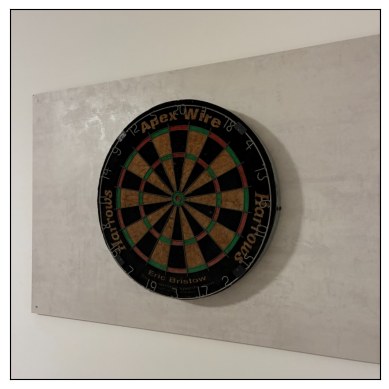

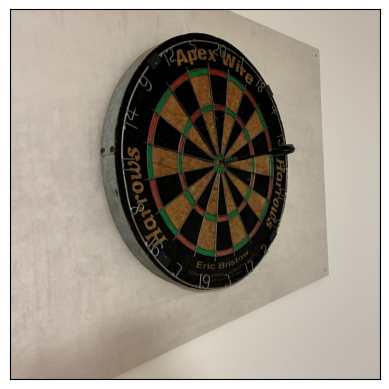

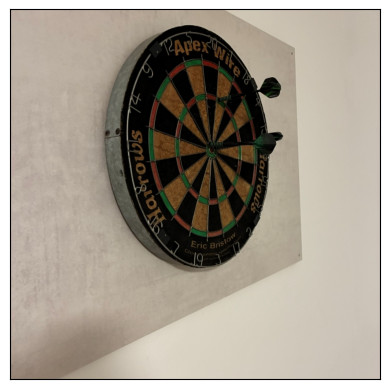

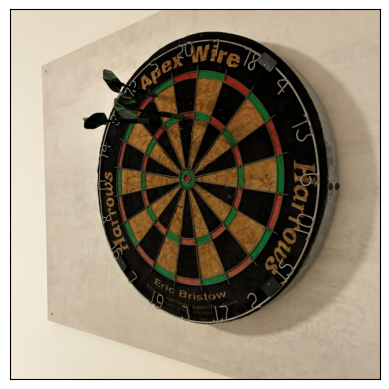

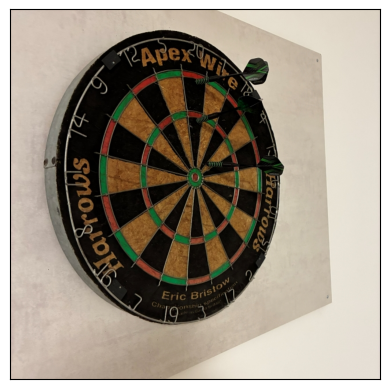

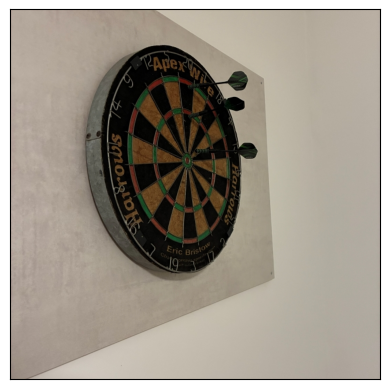

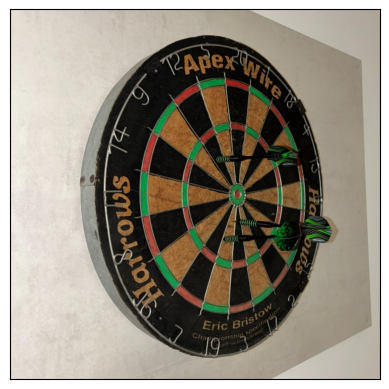

In [41]:
def draw_result(img: np.ndarray, boxes: np.ndarray, labels: np.ndarray | None = None, xywh: bool = True) -> np.ndarray:
    """
    Draws bounding boxes on an image.

    Args:
        img (np.ndarray): The input image (H, W, C), typically uint8 or float.
        boxes (np.ndarray): A NumPy array where each row is a bounding box.
                            If xywh is True: [x, y, w, h] (center_x, center_y, width, height).
                            If xywh is False: [x1, y1, x2, y2] (top-left and bottom-right corners).
        xywh (bool): Flag indicating the format of the bounding box coordinates.

    Returns:
        np.ndarray: The image with the bounding boxes drawn on it,
                    converted to **uint8** format which matplotlib can display.
    """

    if img.dtype != np.uint8:
        if np.issubdtype(img.dtype, np.floating):
            draw_img = (img * 255).astype(np.uint8)
        else:
            draw_img = img.astype(np.uint8)
    else:
        draw_img = img.copy()

    if draw_img.ndim == 2:
        draw_img = cv2.cvtColor(draw_img)

    COLOR = (0, 255, 255)  # Yellow BGR
    THICKNESS = 2

    for i, box in enumerate(boxes):
        box = box.astype(int)
        if xywh:
            # Convert [x, y, w, h] to [x1, y1, x2, y2] format
            x, y, w, h = box
            x1, y1 = int(x - w / 2), int(y - h / 2)
            x2, y2 = int(x + w / 2), int(y + h / 2)
        else:
            # Already in [x1, y1, x2, y2] format
            x1, y1, x2, y2 = box

        # Define points for cv2.rectangle (top-left and bottom-right points)
        pt1 = (x1, y1)
        pt2 = (x2, y2)
        cv2.rectangle(draw_img, pt1, pt2, COLOR, THICKNESS)
        if labels is not None:
            label = labels[i]
            draw_img = cv2.putText(img, str(int(label)), (x1 - 10, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, COLOR)

    draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    return draw_img


def predict(model: YOLO, img_path: Path):
    result = model(img_path, verbose=False)
    return (result[0].boxes.xywh.cpu().numpy(), result[0].boxes.cls.cpu().numpy())


def imshow(img: np.ndarray):
    plt.imshow(img)
    # plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()


for img_path in real_images_path.glob("*.jpg"):
    img = cv2.imread(str(img_path))
    boxes_xywh, labels = predict(model, img_path)
    drawn = draw_result(img, boxes_xywh, labels)
    imshow(drawn)